In [92]:
# 1. Change Bridge nodes in processing results
# 2. Run bridge algo for multiple parameters and rest can be done only once
# 3. Use Global diversified or Deep diversified in the article.
# 4. Suffle the results for every iteration
# 5. 

In [93]:
# %pip install 'networkx<2.7'

In [94]:
# !pip install cdlib

In [95]:
import os
import heapq
import argparse
import threading
import multiprocessing
import sys
import queue


from __future__ import division
import math, time
from copy import deepcopy
import multiprocessing, json
from tqdm import tqdm
import heapq
from heapq import nlargest

import matplotlib.pyplot as plt



#importing libraries that will be used
# import networkx as nx#for creating network
# import numpy as np
# import matplotlib.pyplot as plt#for plotting plots
# import random
# import time#claculating time
# import math
# from collections import Counter
# from itertools import permutations 
# from itertools import combinations

# from collections import defaultdict
# from scipy.io import mmread# to read dataset
# import pandas as pd



In [96]:
#importing libraries that will be used
import networkx as nx#for creating network
from networkx.algorithms import structuralholes
import numpy as np
import matplotlib.pyplot as plt#for plotting plots

import random
import time#claculating time
import math
from collections import Counter
from itertools import permutations 
from itertools import combinations

from collections import defaultdict
from scipy.io import mmread# to read dataset
import pandas as pd

# from cdlib import algorithms

In [97]:
def celf(graph, k):
    """
    Implementation of CELF algorithm for influence maximization in social networks
    
    Args:
    - graph: NetworkX graph object representing the social network
    - k: number of nodes to select
    
    Returns:
    - nodes: list of k nodes with the highest influence scores
    """
    # Initialize variables
    nodes = []
    heap = []
    marg_gains = {}

    # Calculate the marginal gain for each node
    for node in graph.nodes():
        # Run Monte Carlo simulations to estimate the influence of each node
        sim_res = linear_Threshold(graph, nodes + [node])
        marg_gains[node] = len(sim_res) - len(nodes)
        # Add the node to the heap with its marginal gain as key
        heapq.heappush(heap, (-marg_gains[node], node))

    # Select the k nodes with the highest influence scores
    while len(nodes) < k:
        # Get the node with the highest marginal gain
        _, node = heapq.heappop(heap)
        # Recalculate the marginal gain of the selected node
        sim_res = linear_Threshold(graph, nodes + [node])
        marg_gains[node] = len(sim_res) - len(nodes)
        # Add the node to the list of selected nodes
        nodes.append(node)
        # Update the heap with the new marginal gains
        for n in graph.neighbors(node):
            if n not in nodes:
                heapq.heappush(heap, (-marg_gains[n], n))

    return nodes


In [98]:
# import diffusion
from heapdict import heapdict

class Node(object):
    def __init__(self, node):
        self.node = node
        self.mg1 = 0
        self.prev_best = None
        self.mg2 = 0
        self.flag = None
        self.list_index = 0
        
def CELFPP_linear_Threshold(graph, s):
    seeds=list()
    for e in s:
        seeds.append(e)
    influnces = seeds[:]
    queue = influnces[:]
    pre_node_record = defaultdict(float) 
#     print("Queue:",queue)
#     print("Influences:",influnces)
    while len(queue) != 0:
        node = queue.pop(0)
#         print("----------------------------------------------------------------------")
#         print("Take node:",node)
#         print("Neighbour:",graph[node])
        for element in graph[node]:
            if element not in influnces:
#                 print("Element:",element,"prerecored",pre_node_record[element])
                pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight'] 
#                 print(pre_node_record[element])
                if pre_node_record[element] >= graph.nodes[element]['thres']:
#                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
                    influnces.append(element)
                    queue.append(element)
#     influnce_num = len(influnces)
#     print("Seed set:",seeds,"Activated nodes:",influnces)
    return len(influnces)

def celfpp(G, k):
    S = set()
    # Note that heapdict is min heap and hence add negative priorities for
    # it to work.
    Q = heapdict()
    last_seed = None
    cur_best = None
    node_data_list = []

    for node in G.nodes:
        node_data = Node(node)
        node_data.mg1 = CELFPP_linear_Threshold(G,[node])
        node_data.prev_best = cur_best
        node_data.mg2 = CELFPP_linear_Threshold(G,[node, cur_best.node]) if cur_best else node_data.mg1
        node_data.flag = 0
        cur_best = cur_best if cur_best and cur_best.mg1 > node_data.mg1 else node_data
        G.nodes[node]['node_data'] = node_data
        node_data_list.append(node_data)
        node_data.list_index = len(node_data_list) - 1
        Q[int(node_data.list_index)] = - node_data.mg1

    while len(S) < k:
        node_idx, _ = Q.peekitem()
        node_data = node_data_list[node_idx]
        if node_data.flag == len(S):
            S.add(node_data.node)
            del Q[node_idx]
            last_seed = node_data
            continue
        elif node_data.prev_best == last_seed:
            node_data.mg1 = node_data.mg2
        else:
            before = CELFPP_linear_Threshold(G,S)
            S.add(node_data.node)
            after = CELFPP_linear_Threshold(G,S)
            S.remove(node_data.node)
            node_data.mg1 = after - before
            node_data.prev_best = cur_best
            S.add(cur_best.node)
            before = CELFPP_linear_Threshold(G,S)
            S.add(node_data.node)
            after = CELFPP_linear_Threshold(G,S)
            S.remove(cur_best.node)
            if node_data.node != cur_best.node: S.remove(node_data.node)
            node_data.mg2 = after - before

        if cur_best and cur_best.mg1 < node_data.mg1:
            cur_best = node_data

        node_data.flag = len(S)
        Q[node_idx] = - node_data.mg1
    SS=list(S)
#     print("final seed set:",SS)
    return SS

In [99]:
def Greedy(G,k):
    print("in Greedy")
    Dict={}
    mySet1=[]
    V=G.nodes()
    mySet1.clear()
    for i in range(k):
        for v in (V-mySet1):
            mySet1.append(v)
            a=linear_Threshold(G,mySet1)
            Dict[v]=len(a)#influence as value and current node as key
            mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
        Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
        Dict.clear()
        mySet1.append(Keymax)
#     print("Final seed set is:",mySet1,compute_Phi(G,mySet1,comm,k))
    return list(mySet1)


In [100]:
# ratiolevel0bridge=25
# executeDiv()
# processResults()

In [101]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


"""
Model Parameters :  
    GRAPH :
        directed
        node :
            node_id
            label
            probability
        edge :
            source
            target

    n -> population size
    k -> seed set size
    flight_length -> flight lengths of crows
    epoch -> max number of iterations
    awareness_probability-> awareness probability 
    alpha -> constant to calculate node_contribution_index. used for optimisation using random walk
    beta ->  constant to select candidates for random walk
"""


# In[3]:


import random 
import itertools


# In[4]:



#build graph from data
# G = nx.read_gml("test1.gml", label = 'id')

#visualizing the graph
# print(G.nodes(data=True))
# print(G.edges(data=True))

# Define node positions (optional)
# pos = nx.spring_layout(G)
# Get node labels
# node_labels = {node: data['label'] for node, data in G.nodes(data=True)}
# Draw the graph
# nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')


# In[ ]:


# print(G.out_degree())


# In[5]:


#replace for diversity in crow nodes
def replace(j,seed,left):
#     print("In replace:",j,seed,left)
    index = random.randint(0,len(left) - 1)
    seed[j], left[index] = left[index], seed[j]
#     print("seed[j]",seed[j])
    return seed[j]


# returns a list of crow positions 
def initialize_population(G, n, k) :
    nodes_degree = list(G.out_degree())
    nodes_degree = [x[0] for x in sorted(nodes_degree, key=lambda x: x[1])]
#     print("nodes_degree:",nodes_degree)
    population = []
    for i in range(n) :
        seed, left = nodes_degree[:k], nodes_degree[k:]
#         print(seed,left)
        for j in range(k):
            if(random.random() > 0.9):                                                          # REPLACEMENT PARAMETER = 0.5 
                seed[j] = replace(j,seed,left)
        population.append(seed)
    return population


# In[ ]:


# initialize_population(G, 1, 5)


# In[6]:


#initialize a vector r_val[n] where 0<r[i]<1
def initialize_random(n):
#     r_val=dict()
#     for node in G.nodes():
#         print(node)
#         r_val[node]=random.random()
    r_val = [random.random() for i in range(n)]
    return r_val


# In[ ]:


# initialize_random(3)


# In[7]:


# def local_influence_estimate(G : nx.classes.digraph.DiGraph, seed : list) :
#     k = len(seed)
#     seed_set = set(seed)


#     one_neighbours = set()
#     for node_id in seed_set :
#         one_neighbours.update(set(G.neighbors(node_id)))
#     one_neighbours = one_neighbours - seed_set

    
#     two_neighbours = set()
#     for node_id1 in one_neighbours :
#         two_neighbours.update(set(G.neighbors(node_id1)))
#     two_neighbours = two_neighbours - seed_set

#     one_hop_area = len(one_neighbours)
#     if one_hop_area == 0:
#         return k
#     two_hop_area = len(two_neighbours)

#     sigma_0 = k
#     sigma_1 = 0
#     for node_id1 in one_neighbours:
#         val = 1
#         for node_id in seed_set:
# #             print("edge:", node_id,"->",node_id1)
#             if(G.has_edge(node_id,node_id1)) :
# #                 print("Yes edge is present:", node_id,"->",node_id1)
# #                 p = G.nodes[node_id]['probability']
                
# #                 for u, v, data in G.edges(data=True):
# #                     weight = data['weight']
# #                     print(f"Edge {u}-{v} has weight {weight}")
                    
#                 p = G[node_id][node_id1]['weight']
#                 val = val * ( 1 - p)
#         sigma_1 += (1 - val)

#     factor = 0

    
#     for node_id2 in two_neighbours:
#         p = G.nodes[node_id2]['probability']
#         d = 0
#         for node_id1 in one_neighbours:
#             if(G.has_edge(node_id2, node_id1)):
#                 d += 1
#         factor += p*d 
       
#     factor /= one_hop_area
#     factor += 1

#     LIE = sigma_0 + factor * sigma_1
#     return LIE





def local_influence_estimate(graph, seeds):
    influnces = seeds[:]
    queue = influnces[:]
    pre_node_record = defaultdict(float) 
#     print("Queue:",queue)
#     print("Influences:",influnces)
    while len(queue) != 0:
        node = queue.pop(0)
#         print("----------------------------------------------------------------------")
#         print("Take node:",node)
#         print("Neighbour:",graph[node])
        for element in graph[node]:
            if element not in influnces:
#                 print("Element:",element,"prerecored",pre_node_record[element])
                pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight'] 
#                 print(pre_node_record[element])
                if pre_node_record[element] >= graph.nodes[element]['thres']:
#                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
                    influnces.append(element)
                    queue.append(element)
#     influnce_num = len(influnces)
#     print("Seed set:",seeds,"Activated nodes:",influnces)
    return len(influnces)

# In[ ]:


# local_influence_estimate(G, [1,20,30,5,16])


# In[8]:


def get_updated_seed(G,seed, r, flight_length, memory):
#     print("\nin update seed----",seed)
    k = len(seed)

    intersection = set(seed).intersection(set(memory))
    
#     print("intersection:",intersection)
    seed_intersection_memory = [0 if node_id in intersection else 1 for node_id in seed]
#     print("seed_intersection_memory:",seed_intersection_memory)
#     print("r:",r)
    H_arg = [r * flight_length * sim for sim in seed_intersection_memory]
#     print("Harg:",H_arg)
    H_val = [0 if H_arg_j < 1 else 1 for H_arg_j in H_arg]
#     print("Hval_:",H_val)
    left = list(set(G.nodes()) - set(seed))
#     print("left:",left)
    
    seed = [seed[j] if H_val[j] == 0 else replace(j,seed,left) for j in range(k)]
#     print("seed after updation:",seed)
    return seed;    


# In[ ]:


#TEST
# get_updated_seed([1,20,30,5,16], 3, 2, [29,15,32,2,20] )


# In[9]:


def get_seed_random_walk(candidates : list, k : int):
    assert len(candidates) >= k, "b>1 must be"
    temp = [x for x in  candidates]
    seed = []
#     print("Candidate set:",candidates)
    while len(seed) < k :
        node_id = random.choice(temp)
        seed.append(node_id)
        temp.remove(node_id)
#     print("seed set:",seed)
    return seed


# In[ ]:


# TEST
# get_seed_random_walk([5,6,7,2,15,16,54,62,51,1],3)


# In[10]:


def get_best_seed(G, population : list) :
    best_seed = population[0]
    best_lie = local_influence_estimate(G, best_seed)
    for seed in population:
#         print("Seed:",seed,"-->",local_influence_estimate(G, seed))
        current_lie=local_influence_estimate(G, seed)
        if(current_lie > best_lie) :
            best_seed = seed
            best_lie=current_lie
            
#     print("best seed:",best_seed,"-->",local_influence_estimate(G,best_seed))
    return best_seed


# In[ ]:


# get_best_seed(G, [[22,13,16], [1,20,13]])


# In[11]:


import math
def generate_candidates_for_random_walk(G : nx.classes.digraph.DiGraph, alpha : float , beta : float, k : int) :
    #get k-shell values of all nodes
    G.remove_edges_from(nx.selfloop_edges(G))
    k_shell = nx.core_number(G)
    #get structural hole values of all nodes  
#     Deg=G.degree()
#     structural_hole = nx.effective_size(G)
    structural_hole = nx.betweenness_centrality(G)
#     structural_hole = structuralholes.constraint(G)
#     for node in G.nodes():
#         print("node:",node,Deg[node],structural_hole[node], k_shell[node])
    for node_id, sh_val in structural_hole.items():                                                     #ALTERATION
        if  math.isnan(sh_val) or sh_val == 0:  
            structural_hole[node_id] = 1

    #calculating node_contribution_index
    contribution_index =  {}
    k_shell_sum = sum(k_shell)
    
    structural_hole_inv_sum = 0
    for sh_val in structural_hole.values() :
#         print("structuhole:",sh_val,1 / sh_val)
        structural_hole_inv_sum += 1 / sh_val
    
    
#     print("k_shell:",k_shell_sum)
#     print("structure sum:",structural_hole_inv_sum)
    
    for node_id in G.nodes():
        contri_val = (alpha * k_shell[node_id] / k_shell_sum)
        contri_val += ((1 - alpha) * ((1 / structural_hole[node_id]) )/ structural_hole_inv_sum)
#         print("node:",node_id,"->First->",(alpha * k_shell[node_id] / k_shell_sum), "second->",((1 - alpha) * ((1 / structural_hole[node_id]) )/ structural_hole_inv_sum),"final:",contri_val)
        contribution_index[node_id] = contri_val
#         print(contribution_index[node_id])
#     for node in G.nodes():
#         print("node:",node," Deg-->",Deg[node]," ST-->", structural_hole[node]," K_shell-->", k_shell[node]," Cont-->",contribution_index[node_id])
#         print("node:",node,"Deg:",Deg[node]," Cont-->",contribution_index[node])
    
    #generating candidates
    candidates_count = beta * k
    contribution_index = dict(sorted(contribution_index.items(),key=lambda x:x[1],reverse=True))
    
#     print("Sorted:",contribution_index)
    
    candidates = list(contribution_index.keys())
    candidates = candidates[:candidates_count]
    
#     print("Candidate:",candidates)
    return candidates


# In[]:


#TESTING
# generate_candidates_for_random_walk(G, 0.5, 2, 3)


# In[12]:


def local_search(G : nx.classes.digraph.DiGraph, best_seed : list) :
#     print("best seed ",best_seed)
    k = len(best_seed)
    degree = {}
    for node_id in best_seed:
        degree[node_id] = G.degree(node_id)
    
    degree = dict(sorted(degree.items(), key=lambda x : x[1]))
    best_seed = list(degree.keys())
#     print("best seed ",best_seed)
    for j in range(k):
#         print("For seed j:",best_seed[j])
        neighbours = list(set(G.neighbors(best_seed[j]))  - set(best_seed))

        new_best_seed = best_seed
        new_best_lie = local_influence_estimate(G, new_best_seed)
#         print("best seed ",new_best_seed," lie-->",new_best_lie)
# #         print("Neighbour:",neighbours)
        for node_id_index in range(len(neighbours)):
#             print("new_best_seed[j], neighbours[node_id_index]:",new_best_seed[j], neighbours[node_id_index])
            new_best_seed[j], neighbours[node_id_index] = neighbours[node_id_index], new_best_seed[j]
#             print("new_best_seed[j], neighbours[node_id_index]:",new_best_seed[j], neighbours[node_id_index])
#             print("new best seed ",new_best_seed,"-->",local_influence_estimate(G,new_best_seed))
            if(local_influence_estimate(G, new_best_seed) > new_best_lie) :
                new_best_lie = local_influence_estimate(G,new_best_seed)
#                 print("yes:seed is-->",new_best_seed)
                
            else :
#                 print("no")
                new_best_seed[j], neighbours[node_id_index] = neighbours[node_id_index], new_best_seed[j]
                
        best_seed = new_best_seed
#         print("End Best seed set:",best_seed)

    return best_seed


# In[ ]:


# local_search(G, [28,30,33])


# In[13]:



def DCSA(G : nx.classes.digraph.DiGraph, n : int, k : int, epoch : int, flight_length : int , awareness_probability : int ,alpha : float, beta : float):
    """
    Implementation of CROW algorithm for influence maximization in social networks
    
    Args:
    - G: NetworkX directed graph object representing the social network
    - n: crow population size
    - k: number of nodes to select
    - epoch: maximum number of iterations
    - flight_length: length of flight of crows
    - awareness_probability: if crow j is aware of i following him
    
    Returns:
    - nodes: list of k nodes with the highest influence scores
    """

    # Initialize variables
    V = len(G.nodes())      #total number of nodes

    population = initialize_population(G,n,k)         # == x
#     print(population)
    
    memory = initialize_population(G,n,k)     # == m
#     print(memory)
    
    r_val = initialize_random(n)        # == r
#     print("r_val:",len(r_val))
    
    best_seed = get_best_seed(G, population)
#     print("best_seed:",best_seed)
    
    candidates_for_random_walk = generate_candidates_for_random_walk(G, alpha, beta, k)
#     print("candidates_for_random_walk:",candidates_for_random_walk)
    
    for _ in range(epoch) :
        for i in range(n):
            f = i
            while(i == f) :
                f = random.randint(0,n-1)     
            # crow i follows crow f
            if r_val[f] > awareness_probability :
                population[i] = get_updated_seed(G,population[i], r_val[i], flight_length, memory[f])
            else :
                new_seed = get_seed_random_walk(candidates_for_random_walk, k)
#                 print("size:",len(new_seed),k)
#                 print("New seed:",new_seed," -->",local_influence_estimate(G, new_seed),local_influence_estimate(G, population[i]))
                if (local_influence_estimate(G, new_seed) > local_influence_estimate(G, population[i])) :
                    population[i] = new_seed
        
        # update memory of crows
        for i in range(n):
            if local_influence_estimate(G, population[i]) > local_influence_estimate(G, memory[i]) :
                memory[i] = population[i]

        #update best seed 
#         for i in range(n):
#             print(population[i],"-->",local_influence_estimate(G, population[i]))
        
        best_seed = get_best_seed(G, population)
#         print("best seed:",best_seed,"-->",local_influence_estimate(G,best_seed))
        
        
        #update best seed by local search
        new_best_seed = local_search(G, best_seed)
        if(local_influence_estimate(G, new_best_seed) > local_influence_estimate(G, best_seed)) :
            best_seed = new_best_seed

    return best_seed, local_influence_estimate(G, best_seed)


# In[14]:


def DCSA_run(G,k):
    n = 100
    epoch = 100
    flight_length = 2.5
    awareness_probability = 0.1
    alpha = 0.5
    beta = 2
    seed_set,Inf = DCSA(
        G=G, 
        n=n, 
        k=k, 
        epoch=epoch, 
        flight_length=flight_length,
        awareness_probability=awareness_probability, 
        alpha= alpha, 
        beta = beta
        )
    print("sseed set:",seed_set,Inf)
    return seed_set


# DCSA_run(G,k)


# iteration=1
# # # ratiolevel0bridge=0
# Result_file_name="Power_EW_Bridge_BridgeRatio0_1.xlsx"
# executeDiv(iteration)
# processResults(Result_file_name)






In [102]:
import numpy as np
import random
import networkx as nx
import operator


#cuckoo search is a random search stretegy 
# we consider population of host bird/nest=10 and each nest represent a potential solution


def Preprocessing(G,k,comm_set_final,prevseedset,G_new):
    betweenness_centrality = nx.betweenness_centrality(G)
#     print("previous seed set:",prevseedset)
#     print("New graph:",G_new)
    cadidate = list(G_new.nodes)
#     print("new graph seeds:",cadidate)
#     new_cadidate.append(prevseedset)
    new_cadidate=list(set(cadidate) | set(prevseedset))
#     new_cadidate.extend()
#     print("new candidate seeds:",new_cadidate)
    fuzzyset=dict()
#     print(betweenness_centrality)
#     for node, centrality in betweenness_centrality.items():
    for node in new_cadidate:
        x= compute_Phi(G, [node], comm_set_final, k)
#         print("Node:",node, "Betweenness Centrality = ",betweenness_centrality[node],"Diversified value:",x)
        G.nodes[node]['BetCen']=betweenness_centrality[node]
        G.nodes[node]['DV']=x

#     print(G,k)
    print("-----")
    res=dict()
    for node in new_cadidate:
#         print("Node--->",node,"BetCen:",G.nodes[node]['BetCen'],"  DV:",G.nodes[node]['DV'])
#         G.nodes[node]['FuzzyFinalMbmValue']=max(G.nodes[node]['BetCen'],G.nodes[node]['DV'])
        res[node]=max(G.nodes[node]['BetCen'],G.nodes[node]['DV'])
#     print(res)
    
    sorted_items = sorted(res.items(), key=lambda x: x[1], reverse=True)
#     print(sorted_items)
    top_k_items = sorted_items[:k]
#     print("Top k:",top_k_items)
    top_k_keys = [item[0] for item in top_k_items]
#     print("Top nodes:",top_k_keys,k)
#     return res
    return top_k_keys




def example(G,k,communities):
    print(G)
    print("k",k)
    betweenness_centrality = nx.betweenness_centrality(G)
#     print(communities)
    fuzzyset=dict()
    for node, centrality in betweenness_centrality.items():
        x= compute_Phi(G, [node], communities, k)
#         print("Node:",node, "Betweenness Centrality = ",centrality,"Diversified value:",x)
        G.nodes[node]['BetCen']=centrality
        G.nodes[node]['DV']=x

    print(G,k)
    print("-----")
    res=dict()
    for node in G.nodes():
#         print("Node--->",node,"BetCen:",G.nodes[node]['BetCen'],"  DV:",G.nodes[node]['DV'])
        res[node]=max(G.nodes[node]['BetCen'],G.nodes[node]['DV'])
#     print(res)
    
    sorted_items = sorted(res.items(), key=lambda x: x[1], reverse=True)
#     print(sorted_items)
    top_k_items = sorted_items[:k]
#     print("Top k:",top_k_items)
    top_k_keys = [item[0] for item in top_k_items]
#     print("Top nodes:",top_k_keys,k)
    
    return top_k_keys

    




class SocialNetwork:
    def __init__(self, networkx_graph, num_seeds):
        self.networkx_graph = networkx_graph
        self.num_nodes = self.networkx_graph.number_of_nodes()
        self.num_seeds = num_seeds

    
    def influence(self, seeds):
        graph=self.networkx_graph
#         print(seeds,type(seeds))
        seeds=list(seeds)
#         print(seeds,type(seeds))
        
        influnces = seeds[:]
        queue = influnces[:]
        pre_node_record = defaultdict(float) 
    #     print("Queue:",queue)
    #     print("Influences:",influnces)
        while len(queue) != 0:
            node = queue.pop(0)
    #         print("----------------------------------------------------------------------")
#             for ed in graph.edges():
#                 print(ed)
#             print("Take node:",node)
#             print("Neighbour:",graph[node])
            for element in graph[node]:
                if element not in influnces:
    #                 print("Element:",element,"prerecored",pre_node_record[element])
                    pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight'] 
    #                 print(pre_node_record[element])
                    if pre_node_record[element] >= graph.nodes[element]['thres']:
    #                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
                        influnces.append(element)
                        queue.append(element)
    #     influnce_num = len(influnces)
    #     print("Seed set:",seeds,"Activated nodes:",influnces)
        return len(influnces)
    # linear_Threshold(GG,[45,29])

class CuckooSearch:
    def __init__(self, social_network, comm_set_final,prevseedset,G_new,  population_size=10000, levy_flights_exponent=1.5):
        self.social_network = social_network
        self.population_size = population_size
        self.numOfcuckoo=random.randint(1,population_size)
#         self.numOfcuckoo=3
        self.levy_flights_exponent = levy_flights_exponent
        self.res=dict()
        # Initialize the population
#         print(len(self.social_network.networkx_graph))
#         self.population = np.random.randint(0, len(self.social_network.networkx_graph), (self.population_size, self.social_network.num_seeds))
        
#         betweenness_centrality = nx.betweenness_centrality(self.social_network.networkx_graph)
        Closeness_centrality = nx.closeness_centrality(self.social_network.networkx_graph)
#         betweenness_centrality = nx.katz_centrality(self.social_network.networkx_graph,alpha=0.5)
        betweenness_centrality = nx.degree_centrality(self.social_network.networkx_graph)

    
        
        
#         print("previous seed set:",prevseedset)
    #     print("New graph:",G_new)
        cadidate = list(G_new.nodes)
#         print("new graph seeds:",cadidate)
    #     new_cadidate.append(prevseedset)
        new_cadidate=list(set(cadidate) | set(prevseedset))
        self.new_candidate=new_cadidate
    #     new_cadidate.extend()
#         print("new candidate seeds:",new_cadidate)
    #     print(betweenness_centrality)
    #     for node, centrality in betweenness_centrality.items():
        for node in new_cadidate:
            inff= self.social_network.influence([node])
            x=inff/len(self.social_network.networkx_graph.nodes())
#             print("Node:",node, "Betweenness Centrality = ",betweenness_centrality[node],"Diversified value:",x)
            self.social_network.networkx_graph.nodes[node]['BetCen']=betweenness_centrality[node]
            self.social_network.networkx_graph.nodes[node]['close']=Closeness_centrality[node]
            self.social_network.networkx_graph.nodes[node]['DV']=x
            self.social_network.networkx_graph.nodes[node]['res1']=self.social_network.networkx_graph.nodes[node]['BetCen']*self.social_network.networkx_graph.nodes[node]['DV']
            self.social_network.networkx_graph.nodes[node]['res2']=self.social_network.networkx_graph.nodes[node]['close']*self.social_network.networkx_graph.nodes[node]['DV']
#             print("res:",self.social_network.networkx_graph.nodes[node]['res1'])
            
            
        for node in new_cadidate:
#             print("Node:",node,"--->BetCen:",self.social_network.networkx_graph.nodes[node]['BetCen'],":  DV--->",self.social_network.networkx_graph.nodes[node]['DV'],"    min:--->",max(self.social_network.networkx_graph.nodes[node]['BetCen'],self.social_network.networkx_graph.nodes[node]['DV']))
#             self.res[node]=min(self.social_network.networkx_graph.nodes[node]['BetCen'],self.social_network.networkx_graph.nodes[node]['DV'])
            self.res[node]=max(self.social_network.networkx_graph.nodes[node]['res1'],self.social_network.networkx_graph.nodes[node]['res2'])
            
#             self.res[node]=self.social_network.networkx_graph.nodes[node]['res1']
            
            
            
    
    
        k=self.social_network.num_seeds
        kk=2*k
        self.population=[]
        
        
#         degrees = nx.degree(self.social_network.networkx_graph)
#         sorted_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)
#         k=self.social_network.num_seeds
#         kk=2*k
#         top_nodes = [node for node, degree in sorted_degrees[:kk]]
#         self.population=[]
        
        self.influence=dict()
        for i in range(self.population_size):
            new_list = random.sample(new_cadidate, k)
            self.population.append(new_list)
            inf_value=self.social_network.influence(new_list)
#             print(inf_value)
            self.influence[tuple(new_list)]=inf_value
#         print("Population:", self.population)
#         print("solution:,",self.influence)
         
    
        
        self.influence=dict()
        for i in range(self.population_size):
            new_list = random.sample(new_cadidate, k)
            self.population.append(new_list)
            inf_value=self.social_network.influence(new_list)
#             print(inf_value)
            self.influence[tuple(new_list)]=inf_value
    
        self.cuckoo=[]
        self.Cuckooinfluence=dict()
        for i in range(self.numOfcuckoo):
            new_list = random.sample(new_cadidate, k)
            self.cuckoo.append(new_list)
            inf_value=self.social_network.influence(new_list)
            self.Cuckooinfluence[tuple(new_list)]=inf_value

        # Find the best cuckoo
        self.best_cuckoo=dict()
        best_cuckoo_inf = max(self.Cuckooinfluence.items(), key=operator.itemgetter(1))
        keyy=best_cuckoo_inf[0]
        value=best_cuckoo_inf[1]
        
        self.best_cuckoo[tuple(keyy)] = value
        
        
        
        
        
        
        
        
        
        
        
#         print("Cuckoo:---------")
#         for i in self.Cuckooinfluence:
#             print(i, self.Cuckooinfluence[i])
            
            
#         print("Nest:--------")
#         for i in self.influence:
#             print(i,self.influence[i])
        
#         for node in new_cadidate:
#             print("node:",node," IS->",self.social_network.networkx_graph.nodes[node]['DV']," BC->",self.social_network.networkx_graph.nodes[node]['BetCen']," min(res)->",self.res[node])
        
        
    def findupdated_solution_Greedy(self,key,best_cuckoo):
        
        bestcuckoo=best_cuckoo.keys()
#         bck=bestcuckoo[0]
#         print("before best cuckoo:",bestcuckoo)
        bestck=[]
        for n in bestcuckoo:
            for nn in n:
                bestck.append(nn)
                
#         print(" after best cuckoo:",bestck)
#       union of key and best cuckoo
        new_cadidate=list(set(key) | set(bestck))
        solu=dict()
        
        Dict={}
        mySet1=set()
        V=set(new_cadidate)
        mySet1.clear()
        
        k=len(key)
    #     print("Community:",comm,"k:",k)
        for i in range(k):
    #         print("myset ADddding:",mySet1)
            for v in (V-mySet1):
    #             print("v,i:",v,i)
                mySet1.add(v)
    #             print("myset:",mySet1)
                a=compute_Phi(G,list(mySet1),comm,i+1)
    #             print("Phi of ",mySet1," is :",a)
                Dict[v]=a#influence as value and current node as key
                mySet1.remove(v)#remove crrent node from mySet for rest nodes to go for IC
                   #print(Dict)
            if(len(Dict)!=0):
                Keymax = max(zip(Dict.values(), Dict.keys()))[1]# finding node with max influence
    #             CoreDic[Keymax]=Dict[Keymax]
                Dict.clear()
                mySet1.add(Keymax)
        return list(mySet1)
    
    def findupdated_solution(self, key, best_cuckoo):
#         print(key, best_cuckoo)
        
        bestcuckoo=best_cuckoo.keys()
#         bck=bestcuckoo[0]
#         print("before best cuckoo:",bestcuckoo)
        bestck=[]
        for n in bestcuckoo:
            for nn in n:
                bestck.append(nn)
                
#         print(" after best cuckoo:",bestck)
#       union of key and best cuckoo
        new_cadidate=list(set(key) | set(bestck))
        solu=dict()
        
#         print("New list, Given Key and best cuckoo element:",new_cadidate,"--->key:",key, "best cuckoo:-->",list(best_cuckoo.keys()))
#         print("result res:",self.res)
        
        for element in new_cadidate:
            solu[element]=self.res[element]
            
        sorted_items = sorted(solu.items(), key=lambda x: x[1], reverse=True)
#         print("Sorted possible solution:",sorted_items)
        top_k_items = sorted_items[:len(key)]
        top_k_keys = [item[0] for item in top_k_items]
#         print("new solution:",top_k_keys," inf-->",self.social_network.influence(top_k_keys))
#         print("Return best solution:",top_k_keys)
        return top_k_keys

    def update_population(self):    
#         print("In update population____________________________________________________")
        cuckoo_key=self.best_cuckoo.keys()
        best_cuckoo=list(cuckoo_key)[0]
        best_cuckoo_inf=self.best_cuckoo[best_cuckoo]
        
        add_dict=dict()
        dell_dict=dict()
#         print("Rishabh")
#         tt=self.hello()
#         print("self population:",self.population)
#         print("influcen:",self.influence)
        temp_inf=self.influence.copy()
        for k in temp_inf.keys():
            
            tempkeys=list(self.influence.keys())
#             print("temp keys:",tempkeys)
            key=random.choice(tempkeys)
            
#             print("@@@@@@@@@@@@@@@@@@")
#             print("random:",key,"influence ----",self.influence[key])
#             print("best cuckoo:",best_cuckoo,"influence-----",best_cuckoo_inf)
            if(self.influence[key]<best_cuckoo_inf):
#                 print("solution of key is not good--------------")
                newSolution=self.findupdated_solution(key, self.best_cuckoo)
                
                #update new solution
#                 print(" influence:",self.influence)
                new_inf=self.social_network.influence(newSolution)
#                 print("New solution:",newSolution," new influence:",new_inf)
#                 print("old influence:",self.influence[key])
                if(new_inf>self.influence[key]):
#                     print("new influence is better...")
                    dell_dict.clear()
                    add_dict.clear()
                    dell_dict[key]=self.influence[key]
                    add_dict[tuple(newSolution)]=new_inf
                    
#                     print("to be deleted:",dell_dict)
#                     print("To be added:",add_dict)
                    
#                     print("old dictionary:",self.influence)
                    new_key_value_pair = {tuple(newSolution): new_inf}
                    self.influence[tuple(newSolution)] = self.influence.pop(key)
                    self.influence[tuple(newSolution)]=new_inf

                    
                if(new_inf>best_cuckoo_inf):
#                     print("best solution is changed:",best_cuckoo_inf)
                    best_cuckoo_inf=new_inf
                    best_cuckoo=newSolution
                    self.best_cuckoo.clear()
                    self.best_cuckoo[tuple(newSolution)]=best_cuckoo_inf
#                     print(" New best solution is changed:",best_cuckoo)
            else:
#                 print("key has better solution then best cuckoo")
                best_cuckoo_inf=self.influence[key]
                best_cuckoo=key
                self.best_cuckoo.clear()
                self.best_cuckoo[tuple(best_cuckoo)]=best_cuckoo_inf
#                 print(" New best solution is changed:",best_cuckoo)
                
                
            alienfinder = random.uniform(0, 1)
            if(alienfinder<0.25):
#                 print("alien egg is found:",self.new_candidate)
#                 print("key:",key,"-->All nest:", self.influence)
                if key in self.influence.keys():
#                     print("Yes key is present...")
                    new_list = random.sample(self.new_candidate, self.social_network.num_seeds)
                    new_inf=self.social_network.influence(new_list)
#                     print("new generated list:",new_list,":inf-->",new_inf)
                    self.influence[tuple(new_list)] = self.influence.pop(key)
                    self.influence[tuple(new_list)]=new_inf
#                     print("new all nest:",self.influence)
#                 else:
#                     print("key is not present...")
                
            
    def run(self, max_iterations=5):
        for i in range(max_iterations):
            self.update_population()
        cuckoo_key=self.best_cuckoo.keys()
        best_cuckoo=list(cuckoo_key)[0]
#         return self.population[self.best_cuckoo]
        return best_cuckoo




        
    
def CSOrun(G,k,comm_set_final,prevseedset,G_new):
    # Example usage:
#     seed_set=Preprocessing(G,k,comm_set_final,prevseedset,G_new)
#     seed_set=example(G,k,comm_set_final)
    
#     Create a SocialNetwork object
    social_network = SocialNetwork(G, k)
    
#     Create a CuckooSearch object
#     comm_set_final=[[0,1,2,3,4,5,6,7,8,9,10],[11,12,13,14,15]]
    cuckoo_search = CuckooSearch(social_network,comm_set_final,prevseedset,G_new)

#     Run the Cuckoo Search algorithm
    seed_set = cuckoo_search.run()

    return seed_set





In [103]:
def read_txt(path):
  file1 = open(path,'r')
  sender = list()
  receiver = list()

  for i in file1.readlines():
    sender.append(int(i.split(' ')[0]))
    receiver.append(int(i.split(' ')[1].split('\n')[0]))
    
  df = pd.DataFrame(list(zip(sender,receiver)),columns =['source', 'target'])
  return df

In [104]:
def gmltotxt(filename):
    import networkx as nx
    import pandas as pd
    g = nx.read_gml('airlines.gml')
    nx.write_edgelist(g, 'edgelistFile.csv', delimiter=',')
    df = pd.read_csv('edgelistFile.csv')
    file = open("myfile.txt","w")
    for i in range(len(df)):
        x=df.iloc[i][0]
        y=df.iloc[i][1]
        file.write(str(x)+" "+str(y)+"\n")
    file.close()

In [105]:
def linear_Threshold(graph, seeds):
    influnces = seeds[:]
    queue = influnces[:]
    pre_node_record = defaultdict(float) 
#     print("Queue:",queue)
#     print("Influences:",influnces)
    while len(queue) != 0:
        node = queue.pop(0)
#         print("----------------------------------------------------------------------")
#         print("Take node:",node)
#         print("Neighbour:",graph[node])
        for element in graph[node]:
            if element not in influnces:
#                 print("Element:",element,"prerecored",pre_node_record[element])
                pre_node_record[element] = pre_node_record[element] + graph[node][element]['weight'] 
#                 print(pre_node_record[element])
                if pre_node_record[element] >= graph.nodes[element]['thres']:
#                     print(">>>>>>>>>>>>>>>>>>node influeced:",element)
                    influnces.append(element)
                    queue.append(element)
#     influnce_num = len(influnces)
#     print("Seed set:",seeds,"Activated nodes:",influnces)
    return influnces
# linear_Threshold(GG,[45,29])

In [106]:
def displayresult(result,itr,perc):
    print("\n\n\n\n^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

    linestylee=['dashdot','dashed','dotted','-', '--', ':','-.' ]
    
    markerss = ['o','v','s','*','+','x','D','d','X','P']
#     descriptions = ['circle', 'triangle_down','square','star', 'plus','x','diamond', 'thin_diamond','x (filled)','plus (filled)']
    communitiesITR=[]
    Name=[]
    activatednodesITR=[]
    timeITR=[]
    tt=[]
    totalcomm=[]
#     print(itr,result)
    
    for i in result:
        for j in range(len(result[i])):
            Name.append(result[i][j]['Name'])
        break
#     print(Name)
    
#     for i in result:
# #         print(result[i])
#         for j in range(len(result[i])):
#             totalcomm.append(result[i][j]['Total communitites'])
#             break
#     print("Total communitites:",totalcomm)
    
    for i in result:
        active=[]
        comm=[]
        tt=[]
        for j in range(len(result[i])):
            active.append(result[i][j]['length of activated nodes'])
            comm.append(result[i][j]['number of communities'])
            tt.append(result[i][j]['time'])
#             print("time:",len(tt),"comm:",len(comm))
        activatednodesITR.append(active)
        communitiesITR.append(comm)
        timeITR.append(tt)
#     print("Activated nodes:",activatednodesITR)
#     print("Communities:",communitiesITR)
#     print("time:",timeITR)
        
    
        
#     print("hello");
    
    plt.xlabel("Percentage")
    plt.ylabel("Activated nodes")
    plt.title("Activated nodes")
    for i in range(len(activatednodesITR[0])):
        plt.plot(perc,[pt[i] for pt in activatednodesITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
    plt.legend()
    plt.show()
    
    
    plt.xlabel("Percentage")
    plt.ylabel("No of community")
    plt.title("Communitites")
    for i in range(len(communitiesITR[0])):
        plt.plot(perc,[pt[i] for pt in communitiesITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
#     plt.plot(perc,totalcomm,label='Total community',linestyle='%s'%linestylee[-1],marker='%s'%markerss[-1])
    plt.legend()
    plt.show()
    
    
    
    
    print("communities:",len(communitiesITR[0]))
    print("Time:",len(timeITR[0]))
#     print("Percentage:",)
    plt.xlabel("Percentage")
    plt.ylabel("Execution time:")
    plt.title("Execution time")
    for i in range(len(timeITR[0])):
        plt.plot(perc,[pt[i] for pt in timeITR],label = '%s'%Name[i],linestyle='%s'%linestylee[i],marker='%s'%markerss[i])
#     plt.plot(perc,totalcomm,label='Total community',linestyle='%s'%linestylee[-1],marker='%s'%markerss[-1])
    plt.legend()
    plt.show()
    

In [107]:
def findcommunity(G,seedset,k, comm,algoname,exe_time):
#     print ("Communities formed: ",len(comm))
    activated = linear_Threshold(G, seedset)
    noofcommunity=0
    for com in comm:
        if any(x in activated for x in com):
            noofcommunity=noofcommunity+1
#     print("Community we got:",noofcommunity)
    upperBound_dict = {
        'Name':algoname,
        'k_nodes': k,
#         'Total communitites':len(comm),
        'number of communities':noofcommunity,
        'length of activated nodes': len(activated),
        'time':exe_time,
        # 'length of communities': len(community_df['Unnamed: 1'].unique())
    }
    print(upperBound_dict)
    return upperBound_dict



In [108]:
def findresult(G,k,comm_set_final,prevseedset,G_new):

    
    print('\n\n--------------- CSO -------------------')
    st=time.time()
    CSO_seed = CSOrun(G,int(k),comm_set_final,prevseedset,G_new)
    CSOtime=time.time()-st
    CSO_seed=list(CSO_seed)
    print("CSO seed:",CSO_seed)
    CSOresult=findcommunity(G,CSO_seed,k, comm_set_final,'CSO',CSOtime)
    
  
    
#This algorithm is commented because it takes higher execution time, if want to execute then uncomment it and return its result at the bottom the this function.
#     print('\n\n--------------- DCSA -------------------')
#     st=time.time()
#     DCSA_seed = DCSA_run(G,k)
#     DCSAtime=time.time()-st
#     DCSA_seed=list(DCSA_seed)
#     print("DCSA seed:",DCSA_seed)
#     DCSAresult=findcommunity(G,DCSA_seed,k, comm_set_final,'DCSA',DCSAtime)
    

    
    #CELF
    st=time.time()
    CELFseedSet = celf(G,int(k))
    CELFtime=time.time()-st
    print('\n\n--------------- CELF -------------------')
    print("CELF seed set:",CELFseedSet)
    CELFresult=findcommunity(G,CELFseedSet,k, comm_set_final,'CELF',CELFtime)
    
    celfpp
    
     #CELF++
    st=time.time()
    CELFPPseedSet = celfpp(G,int(k))
    CELFPPtime=time.time()-st
    print('\n\n--------------- CELF++ -------------------')
    print("CELFPP seed set:",CELFPPseedSet)
    CELFPPresult=findcommunity(G,CELFPPseedSet,k, comm_set_final,'CELF++',CELFPPtime)
    
    
 
    
#     PAGERANK
    st=time.time()
    pagerank = sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)
    pagerank_seed = [node for node, value in pagerank[0:k]]
    PRtime=time.time()-st    
    print('\n\n--------------- PAGERANK -------------------')
    print("PageRank seed set:",pagerank_seed)
    Pagerankresult=findcommunity(G,pagerank_seed,k, comm_set_final,'PageRank',PRtime)

    #DEGREE
    st=time.time()
    degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    degree_seed = [node for node, value in degree[0:k]]
    Dtime=time.time()-st
    print('\n\n--------------- DEGREE -------------------')
    print("Degree Seed set:",degree_seed)
    Degreeresult=findcommunity(G,degree_seed,k, comm_set_final,'Degree',Dtime)


    
    resultt=[CSOresult,CELFresult,CELFPPresult,Pagerankresult,Degreeresult]
#     resultt=[CSOresult,DCSAresult,CELFresult,CELFPPresult,Pagerankresult,Degreeresult]

    return resultt,CSO_seed


In [109]:
def makeExcel(result,itr,perc):
    timeITR=[]
    Name=[]
    comITR=[]
    activatednodesITR=[]
    for i in result:
        for j in range(len(result[i])):
            Name.append(result[i][j]['Name'])
        break
    for i in result:
        active=[]
        timee=[]
        comm=[]
        for j in range(len(result[i])):
            active.append(result[i][j]['length of activated nodes'])
            comm.append(result[i][j]['number of communities'])
            timee.append(result[i][j]['time'])
        activatednodesITR.append(active)
        comITR.append(comm)
        timeITR.append(timee)
    df=pd.DataFrame()
#     com="Community"
#     for i in range(len(comITR)):
#         comstr=com+"_"+str(perc[i])+"_"+str(perc[i])+"%"
#         df[comstr]=comITR[i]
    time="Time"
    for i in range(len(timeITR)):
        timestr=time+"_"+str(perc[i])+"_"+str(perc[i])+"%"
        df[timestr]=timeITR[i]
#     print("After name",df)
    ICnodes="Activated_Nodes"
    for i in range(len(activatednodesITR)):
        ICnodesstr=ICnodes+"_"+str(perc[i])+"_"+str(perc[i])+"%"
        df[ICnodesstr]=activatednodesITR[i]
    df.insert(0,"Name of Algorithm",Name)
    return df


In [110]:
def execute_TBCD_txt(file_name,perc,kvalues):
    file = file_name + '_edge_list.txt'
    
    edge_list = open(file)
#     print(edge_list)
    no_nodes = 0
    R_seed=[]
    seedSet=[]
    pagerank=[]
    G = nx.DiGraph()
    G_new=nx.DiGraph()
    count=0
    for cc in edge_list:
        count += 1
    print("count:",count,type(edge_list))
    itr=[]
    for i in range(len(perc)):
        vv=int((perc[i]/100)*count)
        itr.append(vv)
    print("Checkpoint for seed set size is at the last edge means after traversing all edge:",itr)
    totalnodes=0
    resultt={}
    edge_list = open(file)
    for l in edge_list:
#         print(l)
        totalnodes=totalnodes+1
        l = l.split(" ")
        s=int(l[0])
        t=int(l[1])
        value = round(random.uniform(0.01,1.0),2)
        G_new.add_edge(s,t,weight=value)
#             G_new.nodes[s]['probability']=value
        G.add_edge(s,t,weight=value)
#         sum_degree = sum(deg for node, deg in G.degree())
        
#         G.nodes[s]['probability']=(G.in_degree(s)/sum_degree)
#         G.nodes[t]['probability']=(G.in_degree(t)/sum_degree)
        G.nodes[s]['probability']=0.01
        G.nodes[t]['probability']=0.01
        
        
        G.nodes[s]['thres']=(G.in_degree(s)/2)
        G.nodes[t]['thres']=(G.in_degree(t)/2)
        
        
        if totalnodes in itr:
            print("\n\n\n\n\n_______________________________________________________________________________________________")
            print("Get result at node:",totalnodes)
            k=int(findk(len(G.nodes)))
            comm_set_final=[]
            for kval in kvalues:
#                 resultt[totalnodes],seedSet=findresult(G,k,comm_set_final,seedSet,G_new)
                resultt[kval],seedSet=findresult(G,kval,comm_set_final,seedSet,G_new)
            G_new.clear()
    displayresult(resultt,itr,kvalues)
    dff = makeExcel(resultt,itr,kvalues)
    return dff



# iteration=1
# # # ratiolevel0bridge=0
# Result_file_name="Power_EW_Bridge_BridgeRatio0_1.xlsx"
# executeDiv(iteration)
# processResults(Result_file_name)

In [111]:
def read_txt(path):
    file1 = open(path,'r')
    sender = list()
    receiver = list()
    for i in file1.readlines():
#         print(int(i.split(' ')[0]),int(i.split('   ')[1]))
        sender.append(int(i.split(' ')[0]))
        receiver.append(int(i.split(' ')[1].split('\n')[0]))
    df = pd.DataFrame(list(zip(sender,receiver)),columns =['source', 'target'])
    df=df.sample(frac=1)
    df.to_csv('input_file_edge_list.txt', sep=' ', index=False,header=False)
    return df
def executeDiv(iteration):
    result_df=pd.DataFrame()
    for i in range(iteration):
#         obj=TBCD_mine()
        kvalues=[2,5,9,15,22,30,40]
#         perc=[10,20,30,40,50,60,70,80,90,100]
        perc=[100]
        filename='LFR_500_0.8'
#         filename='power'
        inputt=filename+'_edge_list.txt'
        read_txt(inputt)
        filename='input_file'
        
#         print(inputt)
#         filename='netscience'

        dff=execute_TBCD_txt(filename,perc,kvalues)
#         print("dff:",dff)
#         print("result_df:",result_df)
        dff2=result_df
        result_df=dff
#         result_df = dff2.concat(dff,ignore_index = True)
#         print(type(dff),type(dff2))
        result_df = pd.concat([dff2,dff])
#         print("end resultdf:",result_df)
        result_df.to_excel('Preprocessed_ResultOFMultipleIterationSeedWise.xlsx')
        
def processResults(filenamee):
    df = pd.read_excel('Preprocessed_ResultOFMultipleIterationSeedWise.xlsx')
    df = df.drop(columns='Unnamed: 0')
    print(df.shape)
    DCSA = df.loc[df['Name of Algorithm']=='DCSA']
    CSO = df.loc[df['Name of Algorithm']=='CSO']
    CELFPP = df.loc[df['Name of Algorithm']=='CELF++']
    CELF = df.loc[df['Name of Algorithm']=='CELF']
    DEGREE = df.loc[df['Name of Algorithm']=='Degree']
    PAGERANK = df.loc[df['Name of Algorithm']=='PageRank']
    
    cols= df.columns
    dcsa = pd.DataFrame(DCSA.iloc[:,1:].mean(),columns = ['DCSA'])
    cso = pd.DataFrame(CSO.iloc[:,1:].mean(),columns = ['CSO'])
    celfpp = pd.DataFrame(CELFPP.iloc[:,1:].mean(),columns = ['CELF++'])
    celf = pd.DataFrame(CELF.iloc[:,1:].mean(),columns = ['CELF'])
    degree = pd.DataFrame(DEGREE.iloc[:,1:].mean(),columns = ['DEGREE'])
    pagerank = pd.DataFrame(PAGERANK.iloc[:,1:].mean(),columns = ['PageRank'])

    
    resultant = pd.concat([cso,dcsa,celfpp,celf,degree,pagerank], axis='columns')
    
    resultant.to_excel(filenamee)
    



In [112]:
def findk(i):#dynamic calculation of k according the percentage of current dataset
  k=(0.01*i)
  if(i==0):
    k=1
  if(k>int(k)):
   k=int(k)+1
  return k

In [113]:
def DisplayInfo():
    print("Title of the paper - Cuckoo Search Optimization-Based Influence Maximization in Dynamic Social Networks")
    print("This code is executed with respect to seed set size at the end of dynmic traversal of graph.")
    print("To adjust the checkpoints, check the percentage \"perc\" in executeDiv() function.")
    print("The seed set size are given in \"kvalues\" in executeDiv() function.")
    print("The population parameters are initialized in the respective functions.")
    print("The results after the multiple iterations are saved in the excel file.")
    print("\n\n\n")

count: 986 <class '_io.TextIOWrapper'>
Checkpoint for seed set size is at the last edge means after traversing all edge: [986]





_______________________________________________________________________________________________
Get result at node: 986


--------------- CSO -------------------
CSO seed: [43, 8]
{'Name': 'CSO', 'k_nodes': 2, 'number of communities': 0, 'length of activated nodes': 8, 'time': 1.1166720390319824}


--------------- CELF -------------------
CELF seed set: [43, 16]
{'Name': 'CELF', 'k_nodes': 2, 'number of communities': 0, 'length of activated nodes': 9, 'time': 0.0}


--------------- CELF++ -------------------
CELFPP seed set: [16, 43]
{'Name': 'CELF++', 'k_nodes': 2, 'number of communities': 0, 'length of activated nodes': 9, 'time': 0.015653371810913086}


--------------- PAGERANK -------------------
PageRank seed set: [478, 487]
{'Name': 'PageRank', 'k_nodes': 2, 'number of communities': 0, 'length of activated nodes': 2, 'time': 0.0}


--------------- DE

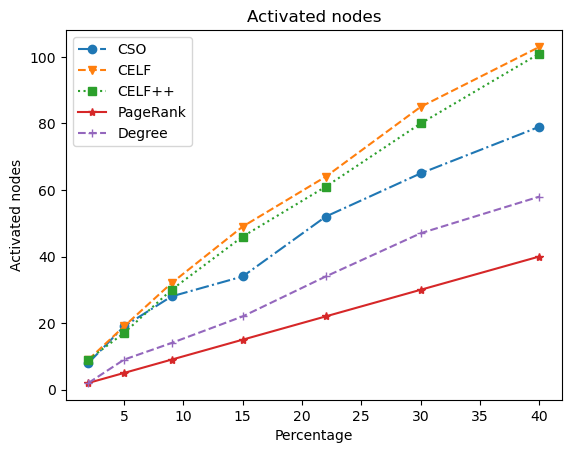

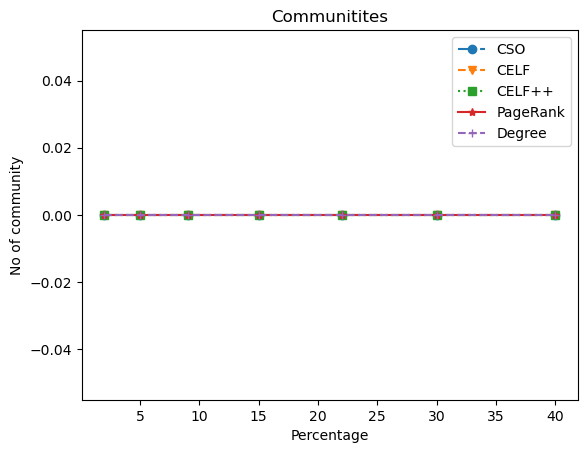

communities: 5
Time: 5


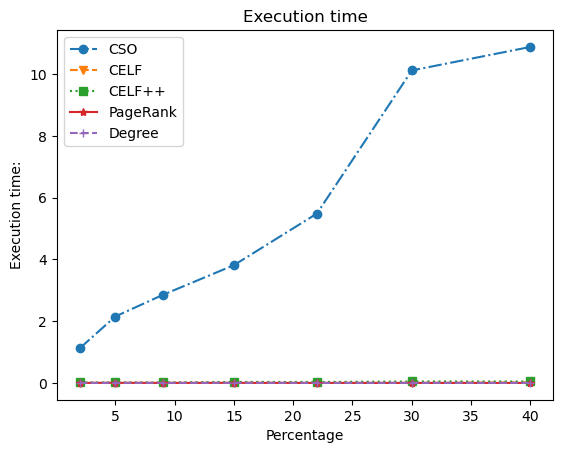

count: 986 <class '_io.TextIOWrapper'>
Checkpoint for seed set size is at the last edge means after traversing all edge: [986]





_______________________________________________________________________________________________
Get result at node: 986


--------------- CSO -------------------
CSO seed: [43, 5]
{'Name': 'CSO', 'k_nodes': 2, 'number of communities': 0, 'length of activated nodes': 10, 'time': 1.1715507507324219}


--------------- CELF -------------------
CELF seed set: [5, 16]
{'Name': 'CELF', 'k_nodes': 2, 'number of communities': 0, 'length of activated nodes': 10, 'time': 0.0}


--------------- CELF++ -------------------
CELFPP seed set: [16, 43]
{'Name': 'CELF++', 'k_nodes': 2, 'number of communities': 0, 'length of activated nodes': 8, 'time': 0.021211624145507812}


--------------- PAGERANK -------------------
PageRank seed set: [478, 465]
{'Name': 'PageRank', 'k_nodes': 2, 'number of communities': 0, 'length of activated nodes': 2, 'time': 0.0031328201293945312}



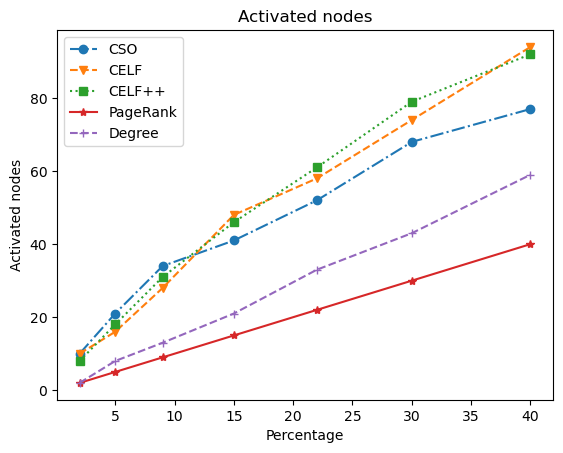

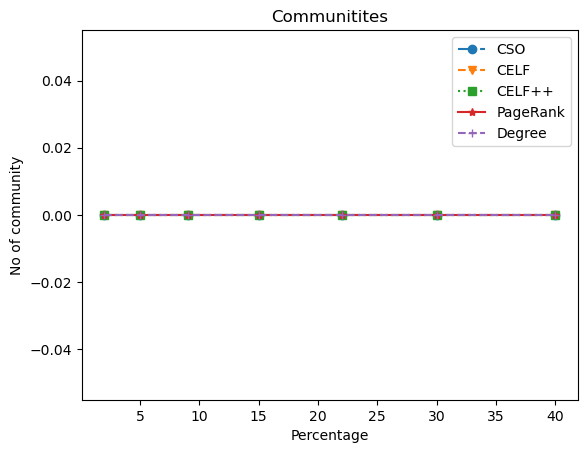

communities: 5
Time: 5


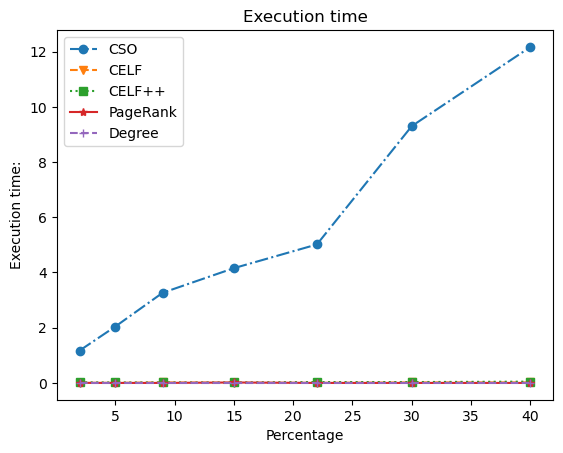

(10, 15)


In [114]:

iteration=2
Result_file_name="Processed_ResultSeedSetWise.xlsx"
executeDiv(iteration)
processResults(Result_file_name)